In [1]:
!pip install -q torchinfo

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import torchinfo
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Prep

In [5]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Resnet Model

### Basic Residual Block

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, stride, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### Bottleneck Block

In [8]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * Bottleneck.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        # print(identity.shape)
        # print(out.shape)
        out += identity
        out = self.relu(out)

        return out

### Resnet Architecture

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, stride=stride, kernel_size=1),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride=stride, downsample=downsample)
        )
        self.in_channels = out_channels * block.expansion

        for _ in range(1, num_blocks):
            layers.append(
                block(self.in_channels, out_channels)
            )
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)
        x = self.fc(x)

        return x

In [10]:
def resnet50():
    return ResNet(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=10)

In [11]:
model = resnet50()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, ep

## Training Process

In [12]:
from tqdm.auto import tqdm

In [13]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.001, max_lr=0.1)

In [14]:
def train_step(model, dataloader, loss_fn, optimizer, scheduler=None, device=device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    if scheduler is not None: scheduler.step(train_loss)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [15]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [16]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler=None, device=device):
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader,
                                           loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader,
                                        loss_fn=loss_fn, device=device)
        
        print(f"Epoch: {epoch+1} | Train_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.4f} | Test_Loss: {test_loss:.4f} | Test_Acc: {test_acc:.4f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [17]:
results = train(model, train_dataloader, test_dataloader, opt, loss_fn, epochs=20, scheduler=scheduler, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

/root/mambaforge/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 | Train_Loss: 1.9647 | Train_Acc: 0.3765 | Test_Loss: 1.8953 | Test_Acc: 0.4728
Epoch: 2 | Train_Loss: 1.6032 | Train_Acc: 0.4814 | Test_Loss: 3.3901 | Test_Acc: 0.5189
Epoch: 3 | Train_Loss: 1.4498 | Train_Acc: 0.5263 | Test_Loss: 2.5218 | Test_Acc: 0.5637
Epoch: 4 | Train_Loss: 1.3344 | Train_Acc: 0.5654 | Test_Loss: 1.3728 | Test_Acc: 0.5789
Epoch: 5 | Train_Loss: 1.1790 | Train_Acc: 0.6196 | Test_Loss: 4.0036 | Test_Acc: 0.6278
Epoch: 6 | Train_Loss: 1.0497 | Train_Acc: 0.6628 | Test_Loss: 2.0751 | Test_Acc: 0.6434
Epoch: 7 | Train_Loss: 1.0616 | Train_Acc: 0.6521 | Test_Loss: 1.6552 | Test_Acc: 0.6083
Epoch: 8 | Train_Loss: 1.0085 | Train_Acc: 0.6752 | Test_Loss: 1.3326 | Test_Acc: 0.6572
Epoch: 9 | Train_Loss: 0.9070 | Train_Acc: 0.6966 | Test_Loss: 0.9322 | Test_Acc: 0.6947
Epoch: 10 | Train_Loss: 0.8409 | Train_Acc: 0.7204 | Test_Loss: 0.8472 | Test_Acc: 0.7161
Epoch: 11 | Train_Loss: 0.7545 | Train_Acc: 0.7474 | Test_Loss: 0.8565 | Test_Acc: 0.7007
Epoch: 12 | Train_L

### Visualising the Losses

In [18]:
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

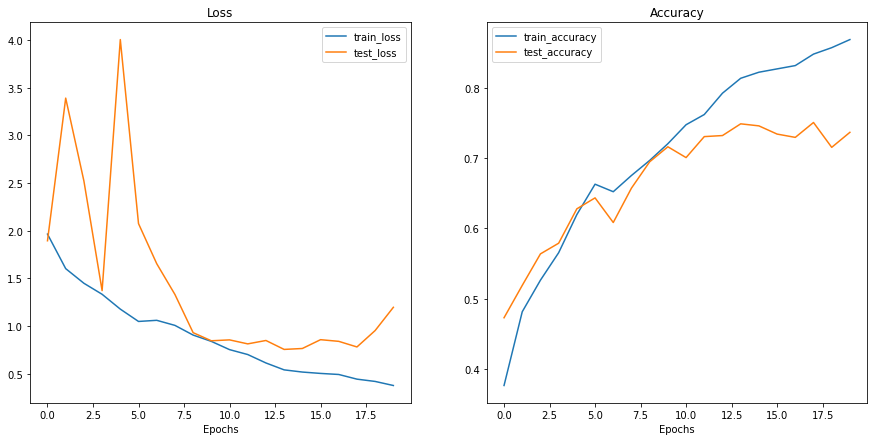

In [19]:
plot_loss_curves(results)

## Checking the Model Predictions

In [20]:
def make_preds(model, data, device=device):
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    
    return torch.stack(pred_probs)

In [28]:
import random
test_samples, test_labels = [], []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 5 (dog)


In [29]:
pred_probs = make_preds(model=model, data=test_samples)
pred_probs[:2]

tensor([[3.5751e-02, 9.2401e-02, 3.6430e-01, 9.9532e-02, 7.2657e-03, 3.4020e-01,
         2.3743e-03, 6.4373e-04, 2.2985e-04, 5.7297e-02],
        [6.4055e-03, 1.4265e-04, 8.0670e-04, 1.3390e-04, 1.2029e-01, 2.4202e-04,
         1.6151e-04, 3.7072e-04, 8.7120e-01, 2.4803e-04]])

In [30]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 8, 4, 2, 4, 7, 8, 8, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


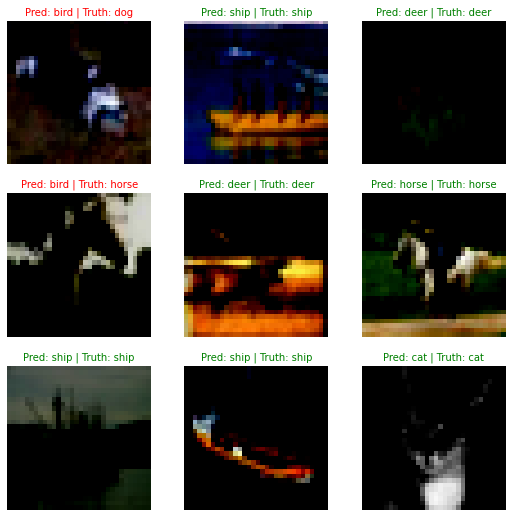

In [31]:
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1, 2, 0))
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

### Confusion Matrix

In [32]:
!pip install -q torchmetrics -U mlxtend

In [33]:
from tqdm.auto import tqdm

y_preds = []
model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making Predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

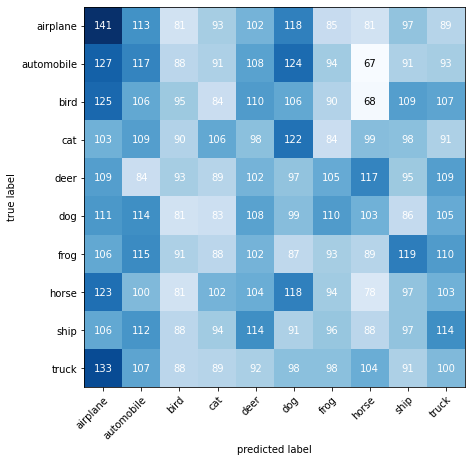

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.Tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names, figsize=(10, 7))